In [2]:
#setup
data_dir='../../Data/Weather'
file_index='SBBBSBSS'
m='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [3]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [4]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [5]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [6]:
data_dir='../../Data/Weather'
file_index='SBBBSBSS'

In [7]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [8]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|    11|[E0 D5 E0 50 90 D...|1913.0|SBBBSBSS|
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|    11|[00 CF 20 50 00 0...|1914.0|SBBBSBSS|
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|     2|[80 C9 80 C9 40 5...|1915.0|SBBBSBSS|
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|    24|[90 D5 40 D6 90 D...|1916.0|SBBBSBSS|
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|    44|[00 CF 00 CF 20 D...|1917.0|SBBBSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [9]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(1851, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

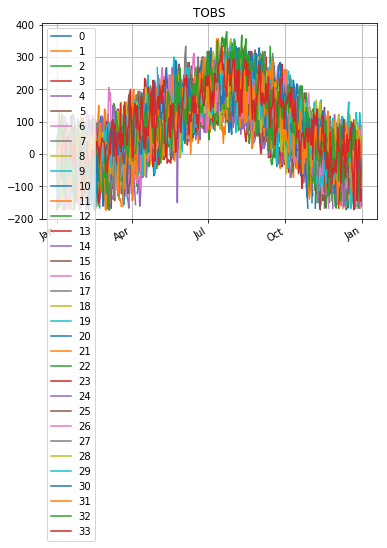

In [10]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:50].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

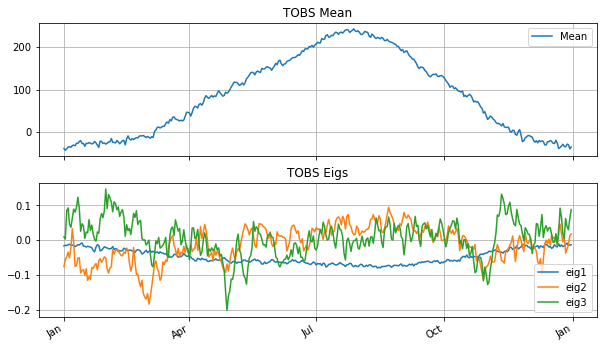

In [11]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

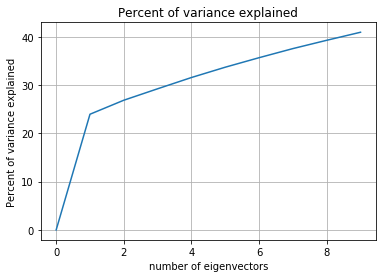

In [12]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [13]:
i=10
v=[np.array(EigVec[:,j]).flatten() for j in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res = residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.326284496606
residual normalized norm  after mean + top eigs: [ 0.66160863  0.65570992  0.6475027 ]


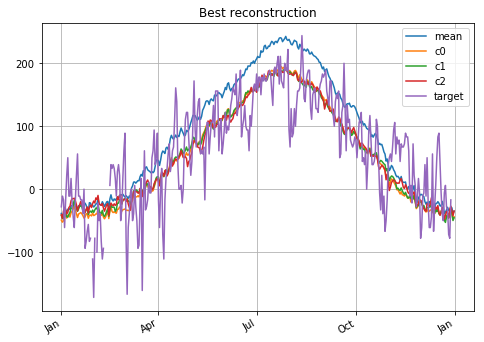

In [14]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [15]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [16]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.343294301829 res_1 : 0.685015957256 res_2 : 0.684890894709 res_3 : 0.685130598325
res_mean : 0.375065540684 res_1 : 0.690974804226 res_2 : 0.639852974614 res_3 : 0.638200690861
res_mean : 0.448761310233 res_1 : 0.653622341634 res_2 : 0.550481622863 res_3 : 0.545367086217


In [17]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1851
after filter 1763


In [18]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [19]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=1, figsize=(15,3.3), res='res_1', coeff='coeff_1'):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='c=%3.2f,r=%3.2f'\
                    %(row[coeff],row[res])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
    return None


In [20]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+-------------------+-------------------+-------------------+
|          res_mean|              res_1|              res_2|              res_3|
+------------------+-------------------+-------------------+-------------------+
|0.7174678498625443| 0.2959592725960696|0.29413197326361173| 0.2908045457062984|
|0.8221149408034312|0.34173283105740454| 0.3243215986014856| 0.2977186979321735|
| 0.595221898401103|0.32639598062894176|0.30725098625931074| 0.2979672172105512|
|0.7366658130835404| 0.3087057892054731|0.30339236058870744|0.30249792013663984|
+------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



In [21]:
def plot_recon_coeff(df, res, coeff, ascend=True):
    df_1=df.filter(df[res]<0.5).sort(df[coeff], ascending=ascend)
    rows=df_1.take(4)
    df_1.select(coeff,res).show(4)
    plot_recon_grid(rows, res=res, coeff=coeff)

+------------------+-------------------+
|           coeff_3|              res_3|
+------------------+-------------------+
| 645.9439175527687|0.48898835074176095|
| 534.0660971269776|0.49676094230035944|
| 335.3452845598575| 0.4286685327618654|
|333.39409870169686| 0.4345206351355854|
+------------------+-------------------+
only showing top 4 rows



/root/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


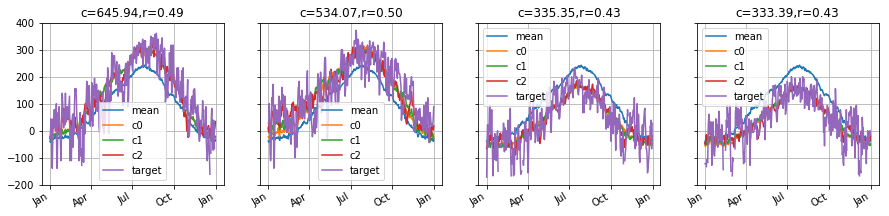

In [22]:
plot_recon_coeff(df3, 'res_3', 'coeff_3', ascend=False)

+-------------------+-------------------+
|            coeff_3|              res_3|
+-------------------+-------------------+
|-337.17467388646764|0.39646016895707914|
| -330.1267333840942|0.35862965614427683|
|-292.68836391245077| 0.3686319877040663|
| -262.0557631484529|0.47157398879983087|
+-------------------+-------------------+
only showing top 4 rows



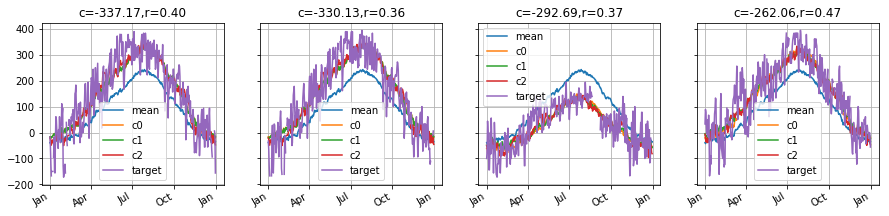

In [23]:
plot_recon_coeff(df3, 'res_3', 'coeff_3', ascend=True)

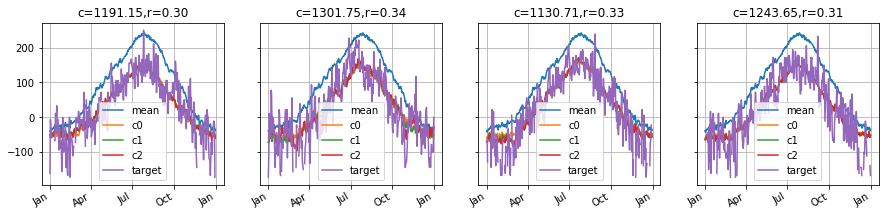

In [27]:
plot_recon_grid(rows)

In [21]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+------------------+
|           res_mean|             res_1|             res_2|             res_3|
+-------------------+------------------+------------------+------------------+
|0.16249979333007475|  1.23357345951353|1.2952706997191121|1.2654665120226873|
|0.17317715055062302|1.1393643737286663|1.1301951815590148|1.1274882920245164|
|0.17356304251090995|1.0841929195235855|1.1077918474235093|  1.07618484851814|
| 0.1471731668925398|1.0926559142831638|1.0390828540760728|1.0729525842525394|
+-------------------+------------------+------------------+------------------+
only showing top 4 rows



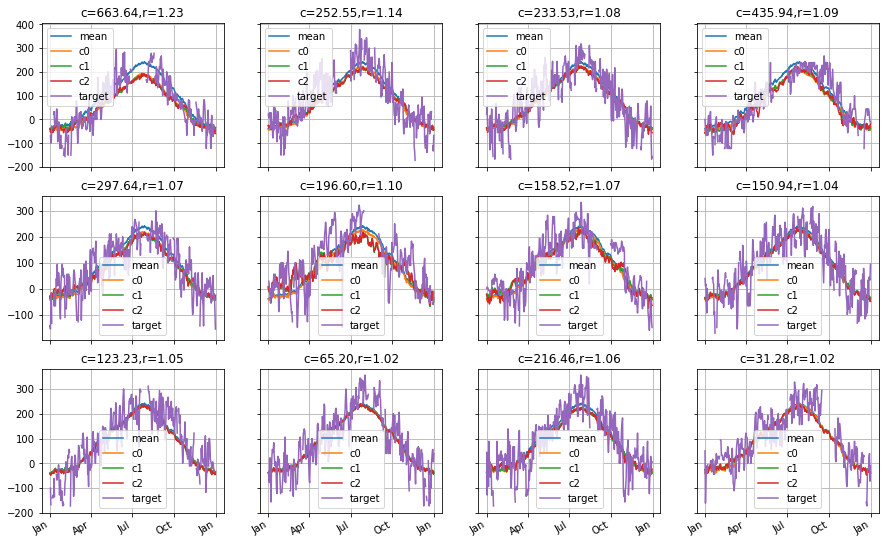

In [22]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

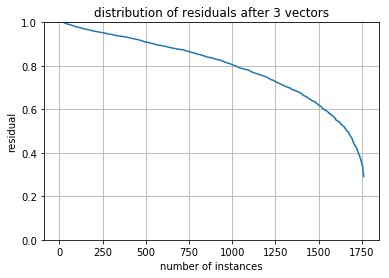

In [23]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [24]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [25]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.5M	../../Data/Weather/US_Weather_SBBBSBSS.parquet
1.9M	../../Data/Weather/decon_BBBSBBBB.parquet
1.9M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
2.5M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
2.5M	../../Data/Weather/decon_SBBBSBSS_PRCP.parquet
1.8M	../../Data/Weather/decon_SBBBSBSS_SNWD.parquet
2.9M	../../Data/Weather/decon_SBBBSBSS_TOBS.parquet
